[  32 2165  450  507  692 1647 1907 2747  240 2601]
[(32, 450), (32, 507), (32, 692), (32, 240), (450, 507), (450, 692), (450, 240), (507, 692), (507, 240), (692, 240), (1647, 1907), (2165, 2747), (2165, 2601), (2747, 2601)]
PCKmeans Iteration 1/100 with max diff 0.9740144575157594
PCKmeans Iteration 2/100 with max diff 0.004610791983437723
PCKmeans Iteration 3/100 with max diff 0.0005135306277970209
PCKmeans Iteration 4/100 with max diff 0.0007069171372229288
PCKmeans Iteration 5/100 with max diff 0.0
PCKmeans Iteration 6/100 with max diff 0.00015930704621947012
PCKmeans Iteration 7/100 with max diff 0.0


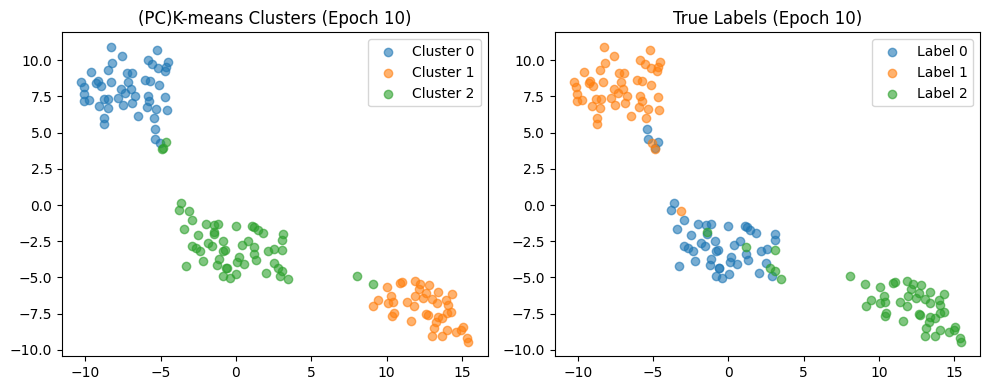


===== Test Results =====
Final Loss: 0.0000
Labels assigned: [2 2 2 ... 1 1 1]
Cluster Centers:
[[5.99990097 2.03974727]
 [1.89415132 6.6979375 ]
 [2.88449236 0.32308388]]
Images Lists (cluster -> indices):
  Cluster 0: [78, 104, 117, 126, 210, 239, 244, 307, 311, 325, 327, 369, 381, 411, 431, 440, 498, 524, 558, 577, 582, 614, 638, 665, 693, 747, 748, 763, 812, 824, 879, 906, 955, 964, 1000, 1001, 1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1070, 1071, 1072, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 110

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_blobs
from clustering import PCKmeans, Kmeans

%matplotlib inline

def test_pckmeans():
    """
    A simple test function for PCKmeans.
    1) Creates synthetic blobs (clusters).
    2) Defines a few must-link and cannot-link constraints.
    3) Runs PCKmeans and prints results.
    """

    # Set random seed for reproducibility
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    # 1) Generate synthetic data
    # Let's create 3 blobs with 2D features.

    # Number of points per cluster
    n = 1000

    # Means for the three clusters (in 2D)
    means = [(3, 0), (6, 2), (2, 6)]

    # Covariance matrices for the three clusters
    covs = [
        [[1, 0], 
        [0, 1]],
        [[1, 0], 
        [0, 1]],
        [[1, 0], 
        [0, 7]]
    ]

    X_list = []
    y_list = []
    for idx, (mean, cov) in enumerate(zip(means, covs)):
        # Draw samples from a 2D Gaussian with the given mean and covariance
        
        X_cluster = np.random.multivariate_normal(mean, cov, n)
        y_cluster = np.full(n, idx)
        X_list.append(X_cluster)
        y_list.append(y_cluster)

    X = np.vstack(X_list)
    y_true = np.concatenate(y_list)


    # 2) Define constraints
    # We will pick a few must-link and cannot-link pairs manually.
    
    # Must-link pairs: pick some points in the same true cluster
    #   e.g., we know points 0 and 1 belong to cluster 0 in y_true => must link them
    #   similarly for points 10 and 11 => cluster 1
    #   and points 20 and 21 => cluster 2
    labeled_indices = np.random.choice(np.arange(3000), size=10, replace=False)
    print(labeled_indices)
    labels = y_true[labeled_indices]
    #construct all must-link pairs according to their labels
    must_link_pairs = []
    for cls in np.unique(labels):
        indices = np.where(labels == cls)[0]
        must_link_pairs += [(labeled_indices[i], labeled_indices[j]) for i in indices for j in indices if i < j]
    
    # construct all cannot-link pairs according to their labels
    cannot_link_pairs = []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] != labels[j]:
                cannot_link_pairs.append((labeled_indices[i], labeled_indices[j]))

    



    constraints = (must_link_pairs, cannot_link_pairs)

    # 3) Instantiate PCKmeans
    # We want k=3 clusters. 
    # Provide constraints, set must_link_weight high to enforce must-link constraints strongly.
    pck = PCKmeans(
        k=3,
        device='cpu',
        plot=True,  # Turn off plotting for this minimal test
        constraints=constraints,
        labeled_indices=labeled_indices,
        max_iter=100,
        #penalty_weight=1.0,      # penalty for cannot-link violation
        #must_link_weight=5.0,    # stronger penalty for must-link violation
    )

    # 4) Run clustering
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    final_loss = pck.cluster(
        fig=fig, 
        axes=axes, 
        X=X, 
        true_labels=y_true, 
        epoch=10, 
        verbose=True
    )

    # 5) Print results: assignments, final cluster centers, constraint violations
    print("\n===== Test Results =====")
    print(f"Final Loss: {final_loss:.4f}")
    print(f"Labels assigned: {pck.labels_}")
    print(f"Cluster Centers:\n{pck.cluster_centers_}")
    print("Images Lists (cluster -> indices):")
    for cluster_id, indices in enumerate(pck.images_lists):
        print(f"  Cluster {cluster_id}: {indices}")

    # Must-link and cannot-link checks
    # must_link_violations, cannot_link_violations = pck._compute_constraint_violations(pck.labels_)
    # print(f"\nMust-link violations: {len(must_link_violations)} / {len(must_link_pairs)}")
    # print(f"Cannot-link violations: {len(cannot_link_violations)} / {len(cannot_link_pairs)}")

    plt.show()
    plt.pause(3)
    # plt.close(fig)

# If you want to run this immediately in your script:
if __name__ == '__main__':
    test_pckmeans()
